## Activity 09

The file ```Cepheids_DATA_errMVerrP.csv``` contains the data for a sample of Cepheids variable stars. Specifically, the columns in the files are:

- MV: absolute magnitude in the V band
- MV_err: error on the absolute magnitude
- LogP: logarithm of the pulsations period
- LogP_err: error on the logarithm of the period

You want to use these data to estimate the best period-luminosity relation (with associated errorbars) that can then be used to calibrate distances in nearby galaxies. 

Using an MCMC software of your choice, write two Bayesian linear regression models, one that does not include errors and one that includes errors in both x and y. Make sure to organize the analysis with the 6 steps discussed in class. 

Plot the estimated posterior distributions of the parameters of the linear models (marginalizing over the intrinsic dispersion), and summarize your results with your best estimate for the parameters and their 95% credibility intervals. 

Plot the data and overplot your best-fit line with the 95% credibility region on the data.

Haoxiang Li Email: li001294@umn.edu

Send me an email and let me know if you find any typos or mistakes. All suggestions are greatly appreciated!

Follow the "Bayesian Analysis Reporting Guidelines" for your final report.

Please refer to "Intro_PyMC_2022.ipynb" and Measurement Error "LinearRegressionME.pdf" for modelling details.

In [2]:
import pandas as pd
data = pd.read_csv("Cepheids_DATA_errMVerrP.csv")
data.head()

MV  MV_err  LogP  LogP_err
0 -3.47    0.09  0.58      0.02
1 -3.15    0.10  0.76      0.02
2 -3.33    0.09  0.70      0.07
3 -5.41    0.08  1.48      0.02
4 -3.70    0.09  0.70      0.02

In [3]:
import sklearn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


from pymc import Model, Normal, Gamma
y = data['MV']
x1 = data['LogP']

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We want to model the absolute magnitude MV as a linear function of the two predictors, LogP=X$_1$. Our statistical model can be written as:

$$Y\sim N(\mu,\lambda^{-1})$$ 

where the expected value μ is a linear function of $X_1$. 

$$\mu = \beta_0 +\beta_1 X_1$$

Where $\beta_0$ is the intercept and $\beta_i$ are the coefficients for $X_i$.

As discussed in lecture, $\sigma$ can be interpreted as the observation (or measurement) error (the same for each measurement $Y_i$), or as the intrinsic scatter in a physical relation, possibly induced by an uknown variable.

We will use zero mean normal priors with variance of 10 to both regression parameters, β. We will also chose a half normal distribution for the variance, as the variance is positive. So:

$$\beta \sim {\rm N_2}(0,10)$$
$$\lambda \sim {\rm Gamma}(1,1)$$

In [5]:
# one that does not include errors
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1./10, shape=2)
    precision = Gamma('precision', alpha=1, beta=1)
    # Expected value of outcome
    mu = beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [6]:
from pymc import find_MAP
#import pprint
#pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
map_estimate

{'beta': array([-2.0061211 , -1.94716412]),
 'precision_log__': array(1.01673194),
 'precision': array(2.76414659)}

In [7]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")

with basic_model:
    start = find_MAP() 
    # draw "draws" posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)

Running on PyMC v4.3.0


C:\Users\43889\AppData\Local\Temp/ipykernel_6928/3091267548.py:10: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.


In [8]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [9]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int32 0 1 2 3
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int32 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -1.869 -2.035 ... -2.078
    precision   (chain, draw) float64 2.773 2.737 2.803 ... 2.777 2.529 2.918
Attributes:
    created_at:                 2022-11-06T22:45:44.677018
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              168.56007528305054
    tuning_steps:               1000

Posterior analysis

array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'precision'}>,
        <AxesSubplot: title={'center': 'precision'}>]], dtype=object)

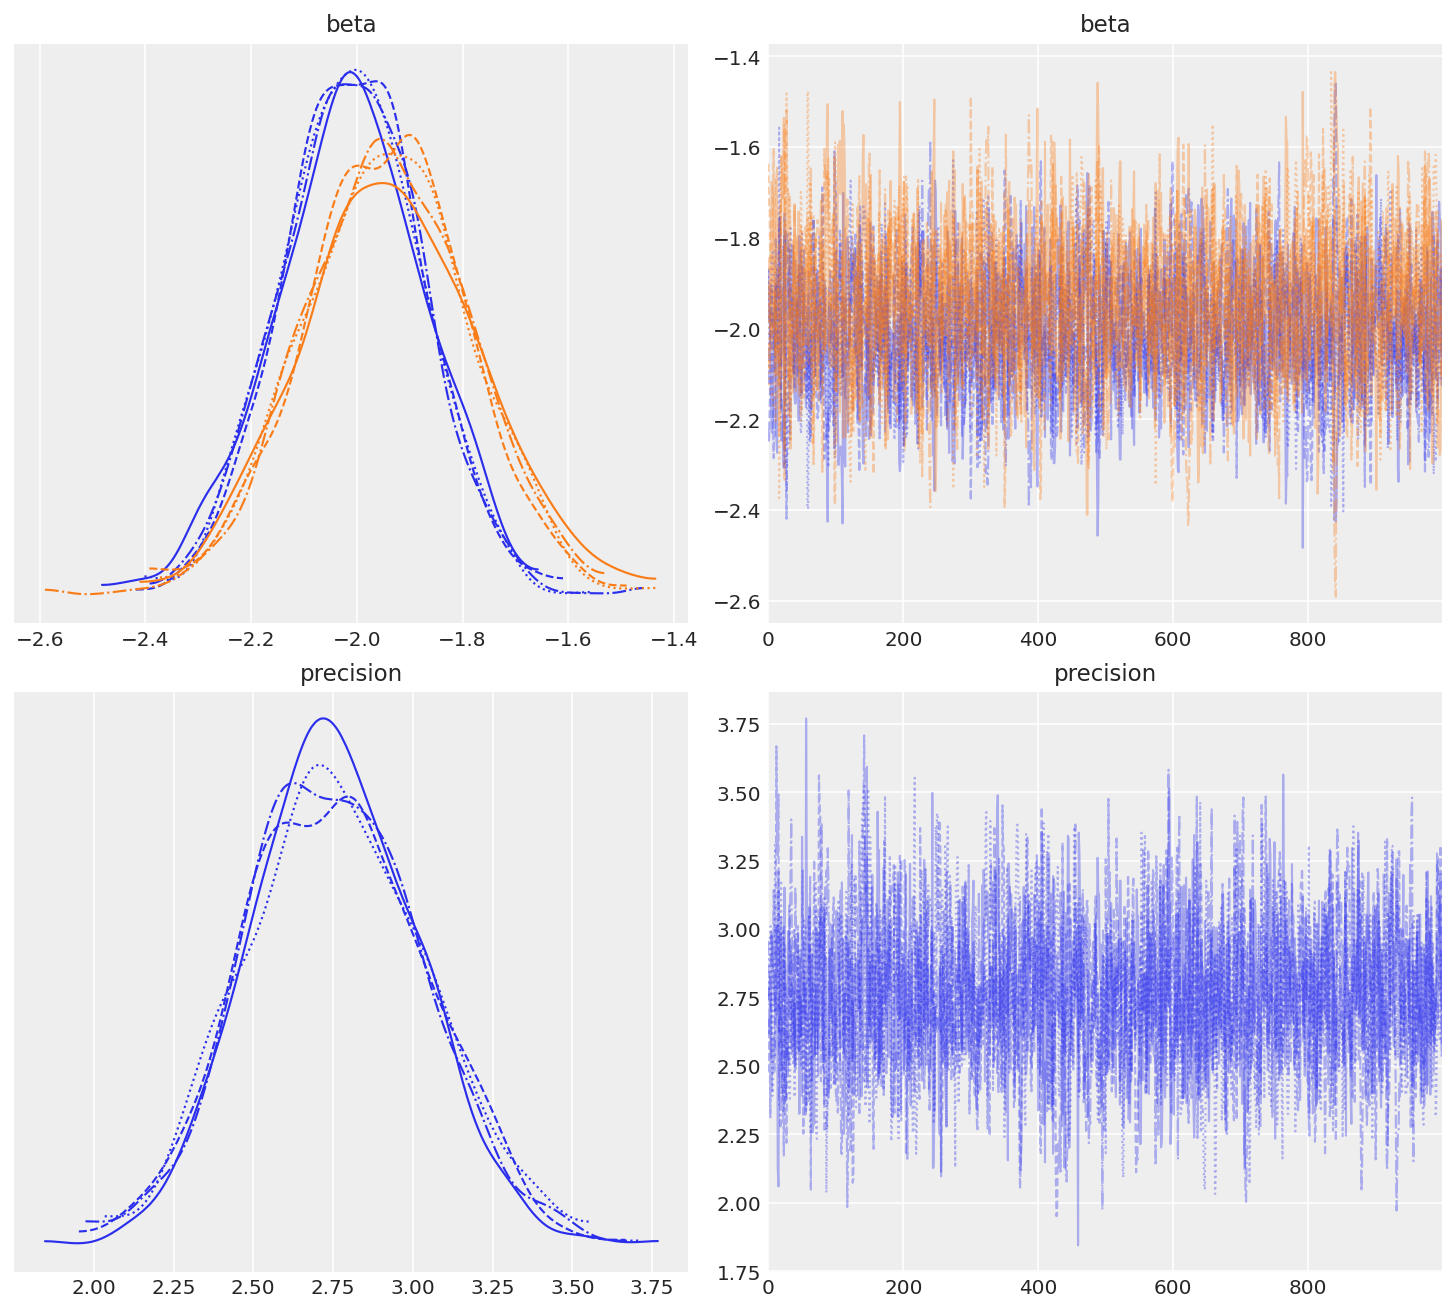

In [10]:
az.plot_trace(trace,figsize=(10, 9))

In [11]:
az.summary(trace, hdi_prob=0.95) # HDI Highest Density Interval 5%

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -2.010  0.134    -2.273     -1.754      0.004    0.003    1367.0   
beta[1]   -1.943  0.158    -2.245     -1.629      0.004    0.003    1364.0   
precision  2.757  0.273     2.236      3.290      0.006    0.004    2008.0   

           ess_tail  r_hat  
beta[0]      1549.0    1.0  
beta[1]      1523.0    1.0  
precision    1938.0    1.0

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'precision'}>], dtype=object)

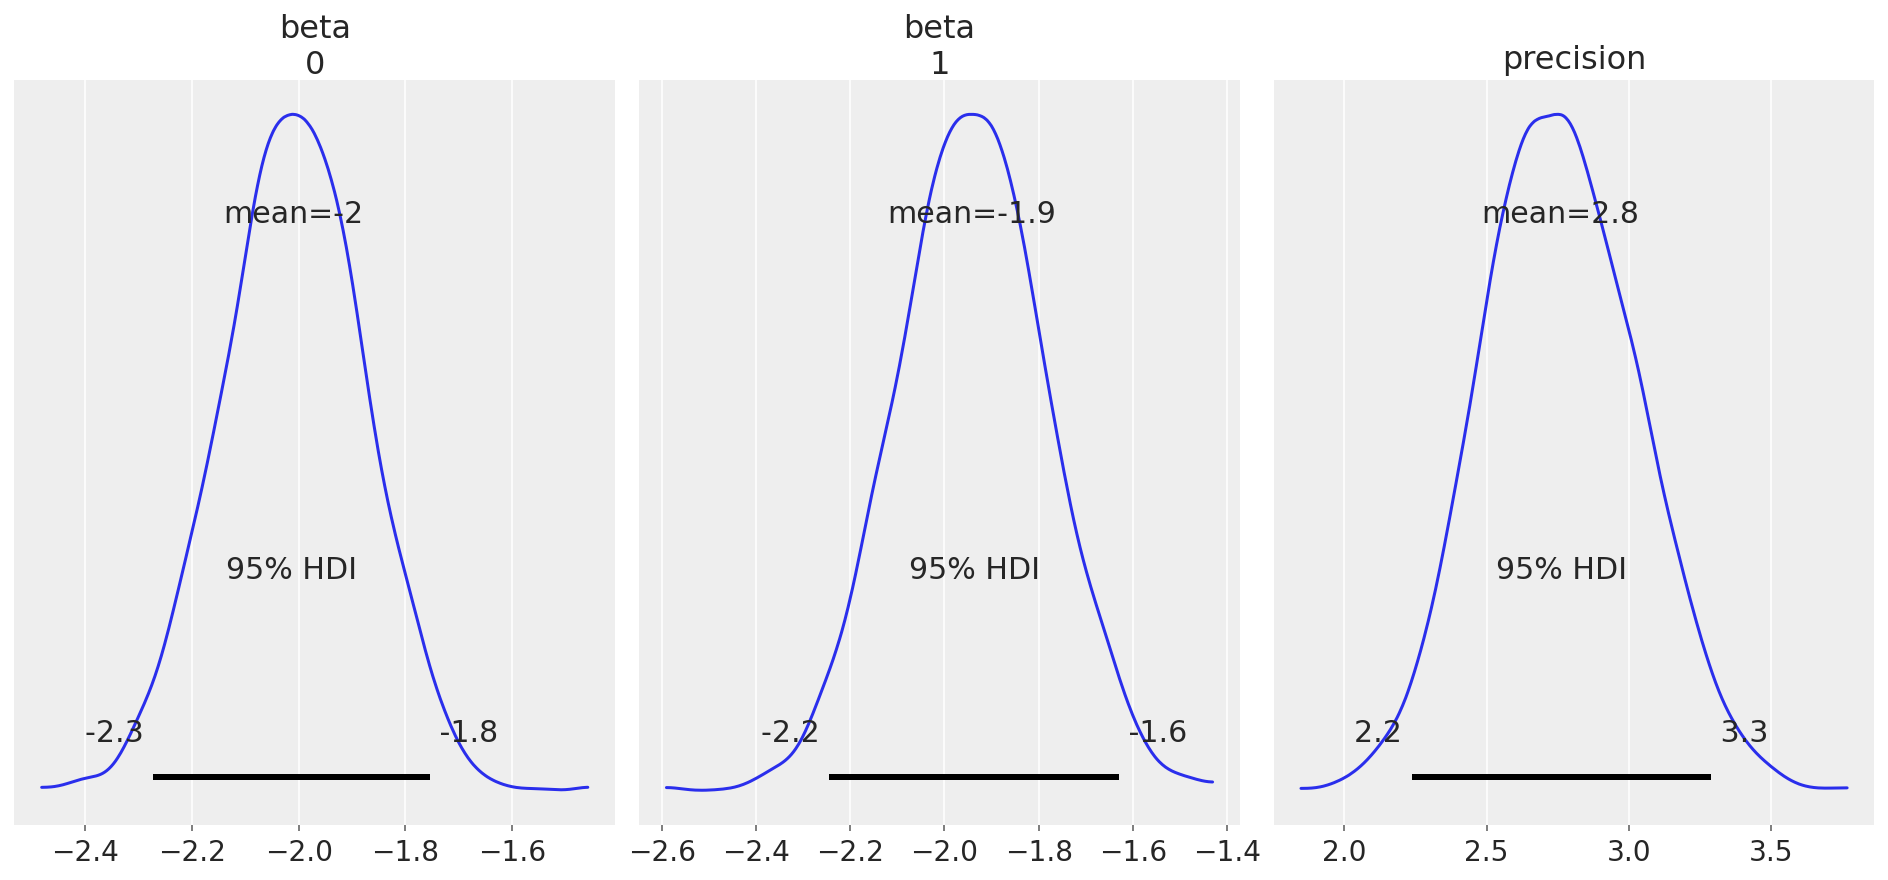

In [12]:
az.plot_posterior(trace, figsize=(13, 6), hdi_prob=0.95)

In [39]:
# ess
print(az.ess(trace, var_names=['beta']))

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 0 1
Data variables:
    beta        (beta_dim_0) float64 5.024e+03 5.111e+03


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

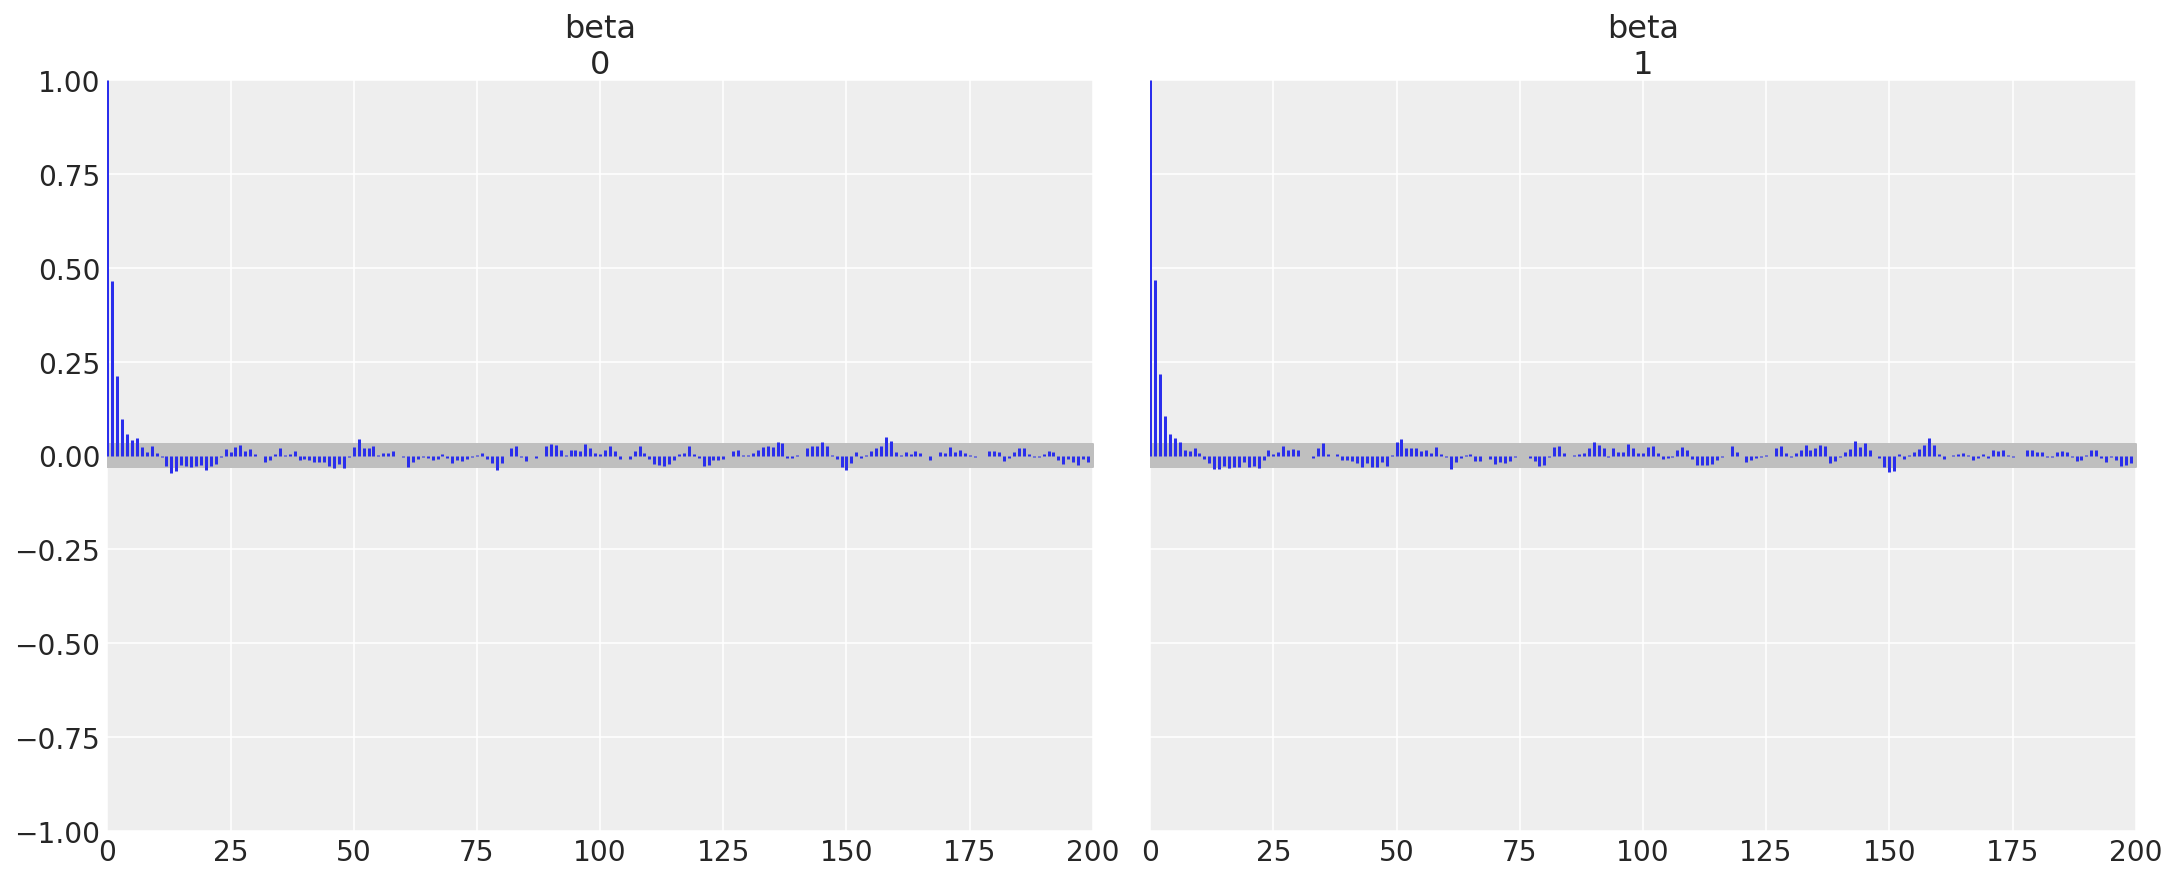

In [14]:
# acf
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200, combined=True, figsize=(15, 6))

In [15]:
# Posterior Predictive Sampling
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 203)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int32 0 1 2 3 4 5 6 ... 197 198 199 200 201 202
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -3.374 -4.305 ... -4.158
Attributes:
    created_at:                 2022-11-06T22:46:12.103748
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<AxesSubplot: xlabel='Y_obs / Y_obs'>

C:\Users\43889\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


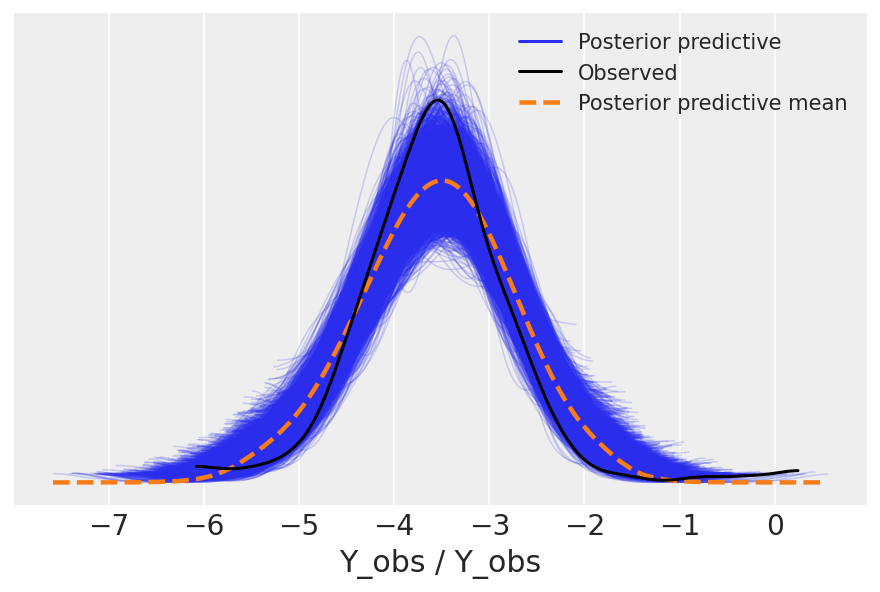

In [16]:
az.plot_ppc(trace)

In [17]:
az.summary(trace.posterior_predictive, hdi_prob = 0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Y_obs[0]   -3.136  0.606    -4.306     -1.920       0.01    0.007    4027.0   
Y_obs[1]   -3.496  0.612    -4.702     -2.356       0.01    0.007    3902.0   
Y_obs[2]   -3.349  0.607    -4.517     -2.145       0.01    0.007    3850.0   
Y_obs[3]   -4.893  0.602    -6.021     -3.655       0.01    0.007    3687.0   
Y_obs[4]   -3.358  0.611    -4.551     -2.151       0.01    0.007    3900.0   
...           ...    ...       ...        ...        ...      ...       ...   
Y_obs[198] -3.607  0.600    -4.738     -2.439       0.01    0.007    3796.0   
Y_obs[199] -3.473  0.613    -4.599     -2.235       0.01    0.007    3797.0   
Y_obs[200] -2.354  0.598    -3.580     -1.217       0.01    0.007    3496.0   
Y_obs[201] -3.945  0.623    -5.129     -2.719       0.01    0.007    4032.0   
Y_obs[202] -4.225  0.598    -5.417     -3.088       0.01    0.007    3875.0   

            ess_tail  r_hat  
Y_obs[0]      3642.0    1.0  
Y_obs[1]      3931.0    1.0  
Y_obs[2]      3889.0    1.0  
Y_obs[3]      3622.0    1.0  
Y_obs[4]      3971.0    1.0  
...              ...    ...  
Y_obs[198]    3784.0    1.0  
Y_obs[199]    3912.0    1.0  
Y_obs[200]    3881.0    1.0  
Y_obs[201]    3617.0    1.0  
Y_obs[202]    3611.0    1.0  

[203 rows x 9 columns]

One that includes errors in both x and y. 

Model: refer to LinearRegressionME.pdf 

Section: Bayesian linear regression with measurement error

We want to model the absolute magnitude MV as a linear function of the two predictors, LogP=Xstar$_1$. Our statistical model can be written as:

$$Ystar_i \sim N(Y_i,a^{-1})$$ 
$$Y_i\sim N (X_i\beta, \tau^{-1})$$
$$Xstar_i \sim N(X_i, b^{-1})$$
$$X_i\sim N(0, c^{-1}),\ iid$$
$$\beta\sim N_2(0, d^{-1}I_2)$$
$$\tau\sim Gamma(e, f)$$


In [18]:
a = data["MV_err"] ** (-2)
b = data["LogP_err"] ** (-2)
ystar = data["MV"]
xstar = data["LogP"]
c = d = 1e-3
e = f = 0.5

In [19]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=data.shape[0])
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=ystar)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=xstar)

In [20]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
pp.pprint(map_estimate)


{   'X1': array([ 0.5800336 ,  0.75887122,  0.69258614,  1.47960033,  0.69993156,
        0.49066119,  1.1881784 ,  0.80719397,  0.60880316,  0.81903903,
        0.57700564,  0.60931302,  0.72952981,  0.89963481,  0.62966298,
        1.22927746,  0.68899763,  1.17264073,  0.6884419 ,  1.24834781,
        0.78895433,  0.72927138,  0.62990621,  1.14654275,  0.9902137 ,
        0.57966792,  0.39575776,  0.9005416 ,  0.32008337,  0.4899754 ,
        0.41781603,  0.80900066,  0.78700605,  0.7606559 ,  0.96949809,
        0.82804817,  1.02884145,  0.76010096,  0.96890007,  0.53942429,
        0.85966375,  1.43452818,  0.7689992 ,  0.76035939,  1.24871265,
        0.58012481,  0.8782091 ,  0.81032321,  0.87954287,  1.61913301,
        0.48929391,  0.77966084,  1.21585578,  1.15824515,  1.06951179,
        0.90035501,  1.07939814,  0.66987726,  1.30883823,  0.62943484,
        0.98923524,  0.79950955,  0.55937952,  0.60947961,  0.57953162,
        0.73952257,  0.60973826,  1.09924685,  1.2296

In [21]:
trace.posterior.dims

Frozen({'chain': 4, 'draw': 1000, 'beta_dim_0': 2})

In [22]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model:
    start = find_MAP() 
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step

# These general samplers take too long.
# The dimension is too high due to X and Y random vectors.
# Suggest using the Gibbs samplers in R with code provided in LinearRegressionME.pdf page 11. 

Running on PyMC v4.3.0


C:\Users\43889\AppData\Local\Temp/ipykernel_6928/195832788.py:13: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1215 seconds.


In [23]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, X1_dim_0: 203, beta_dim_0: 2,
                 Y_dim_0: 203)
Coordinates:
  * chain       (chain) int32 0 1 2 3
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * X1_dim_0    (X1_dim_0) int32 0 1 2 3 4 5 6 7 ... 196 197 198 199 200 201 202
  * beta_dim_0  (beta_dim_0) int32 0 1
  * Y_dim_0     (Y_dim_0) int32 0 1 2 3 4 5 6 7 ... 196 197 198 199 200 201 202
Data variables:
    X1          (chain, draw, X1_dim_0) float64 0.6042 0.7679 ... 1.005 1.069
    beta        (chain, draw, beta_dim_0) float64 -1.995 -2.011 ... -2.13 -1.838
    Y           (chain, draw, Y_dim_0) float64 -3.321 -3.228 ... -3.5 -4.786
    tau         (chain, draw) float64 2.033 1.759 2.143 ... 1.735 2.172 2.094
Attributes:
    created_at:                 2022-11-06T23:06:59.560529
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              1214.5903809070587
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

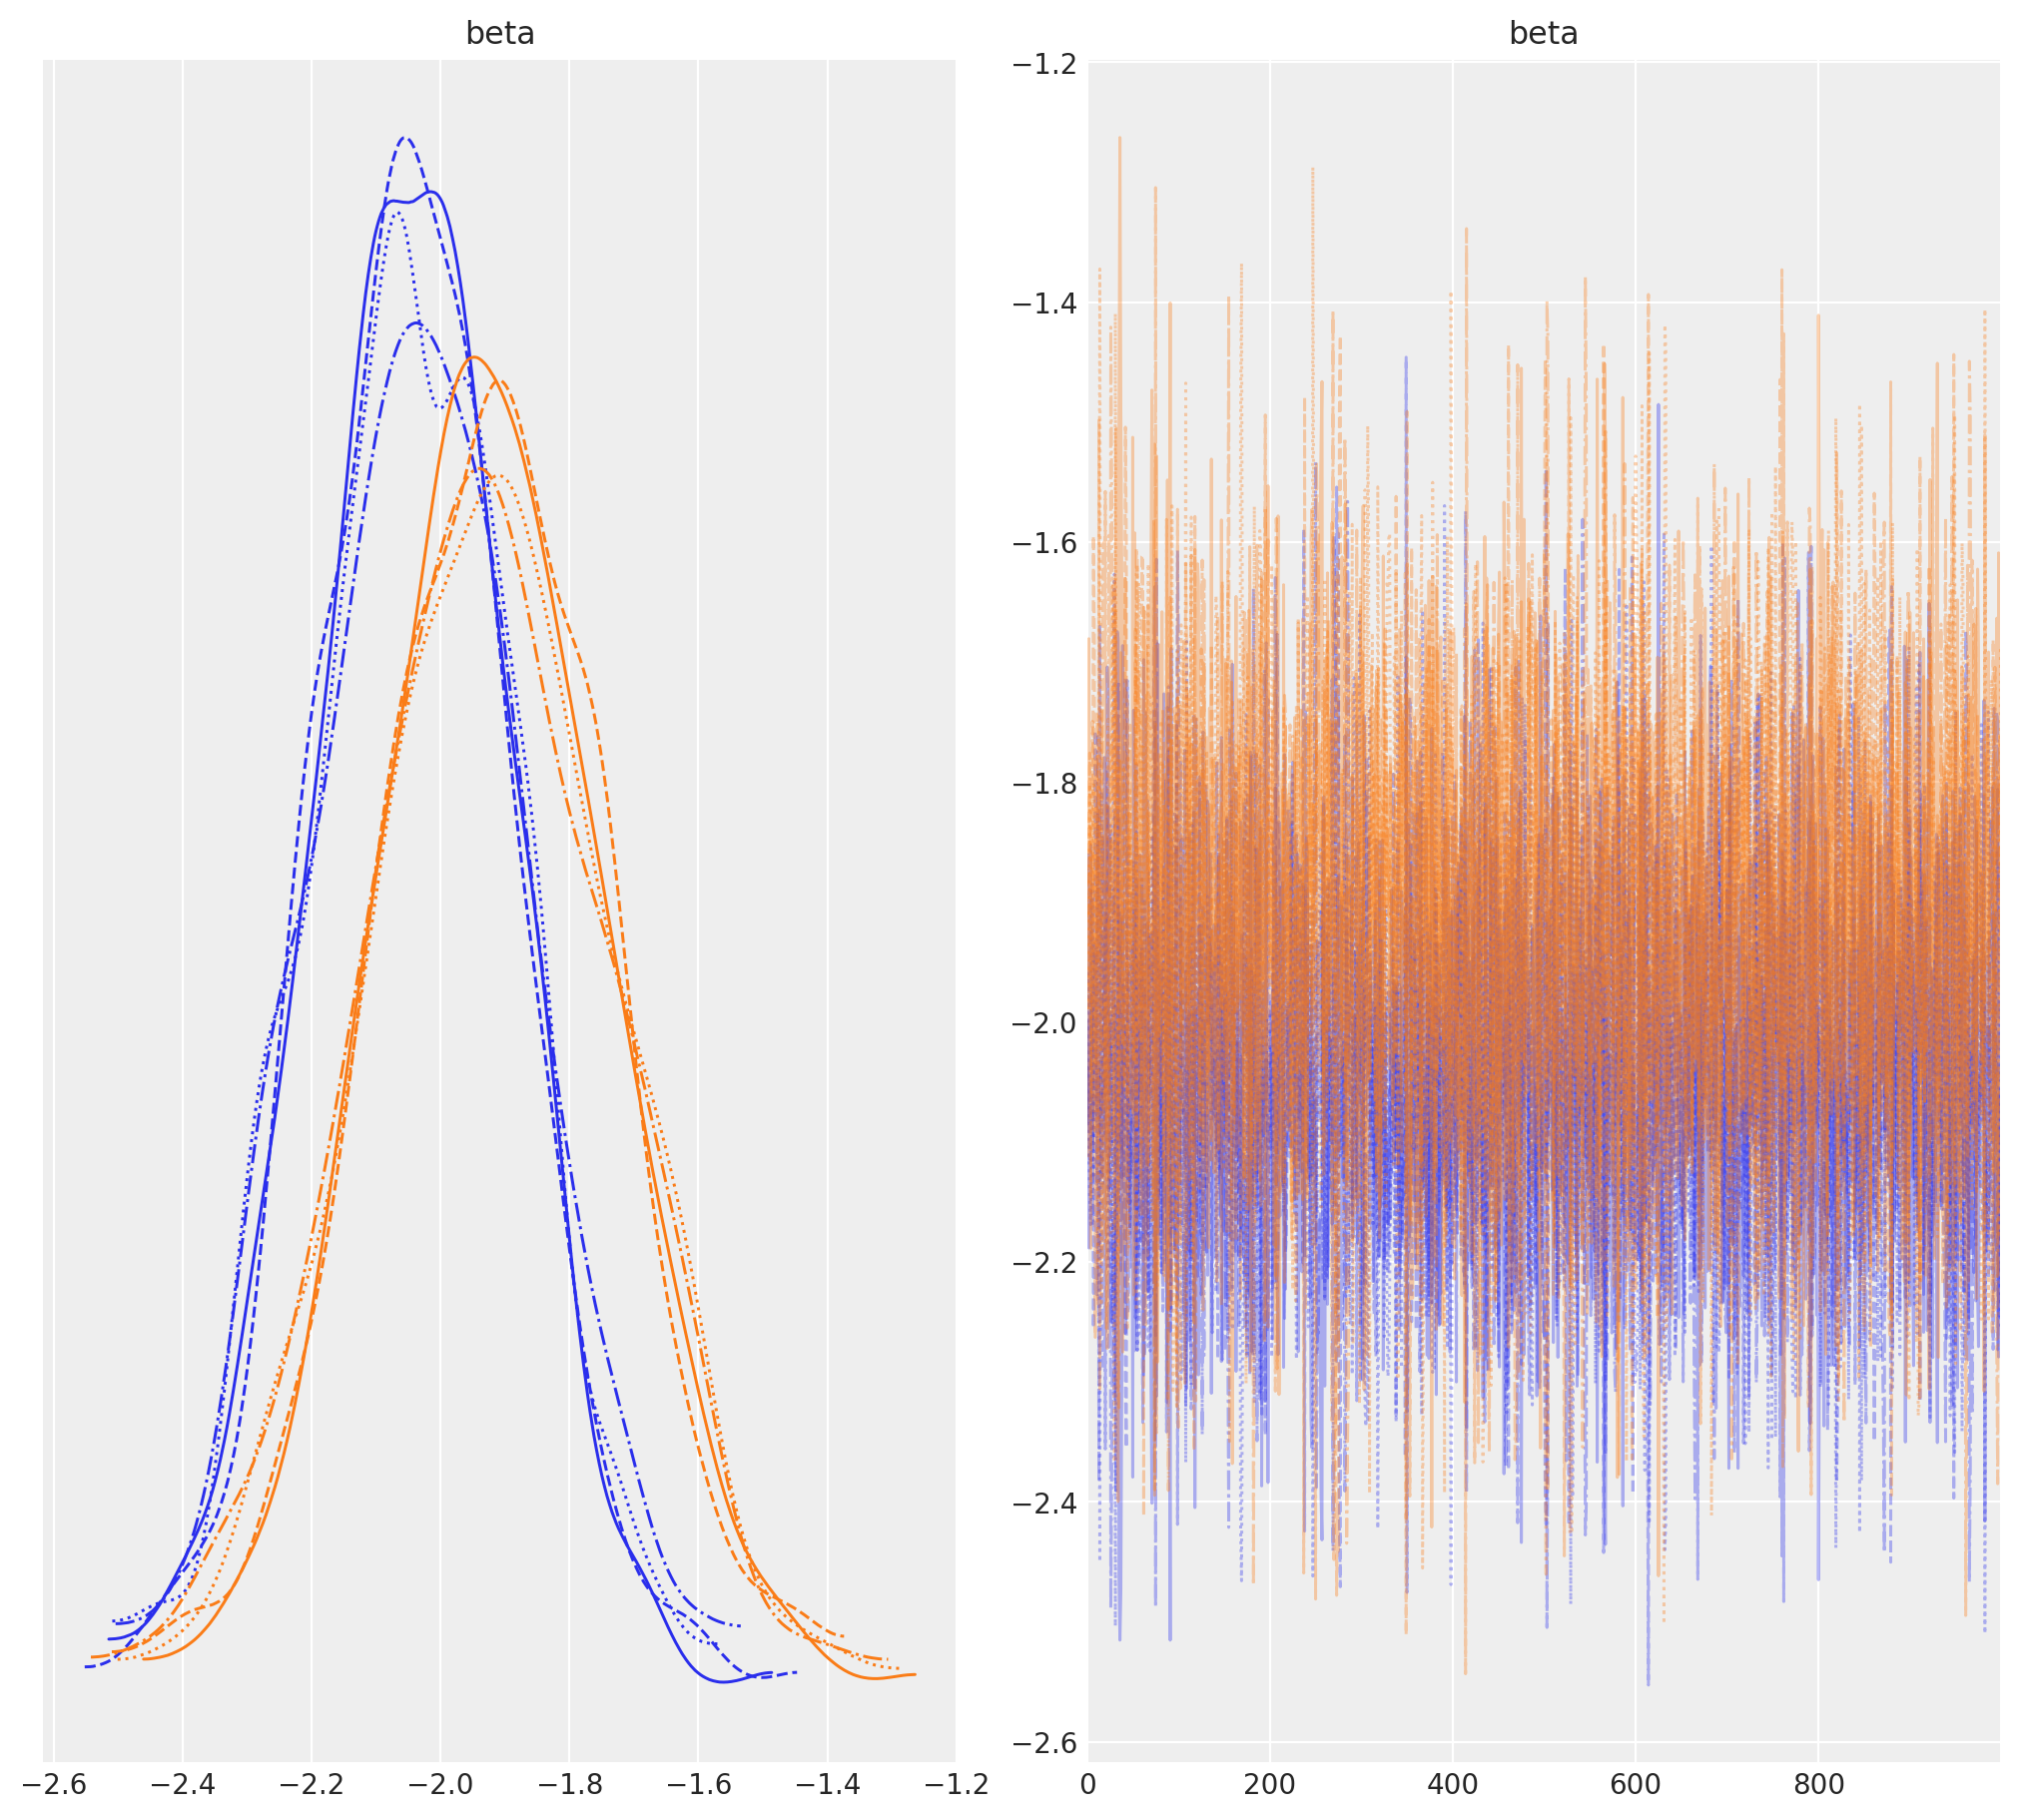

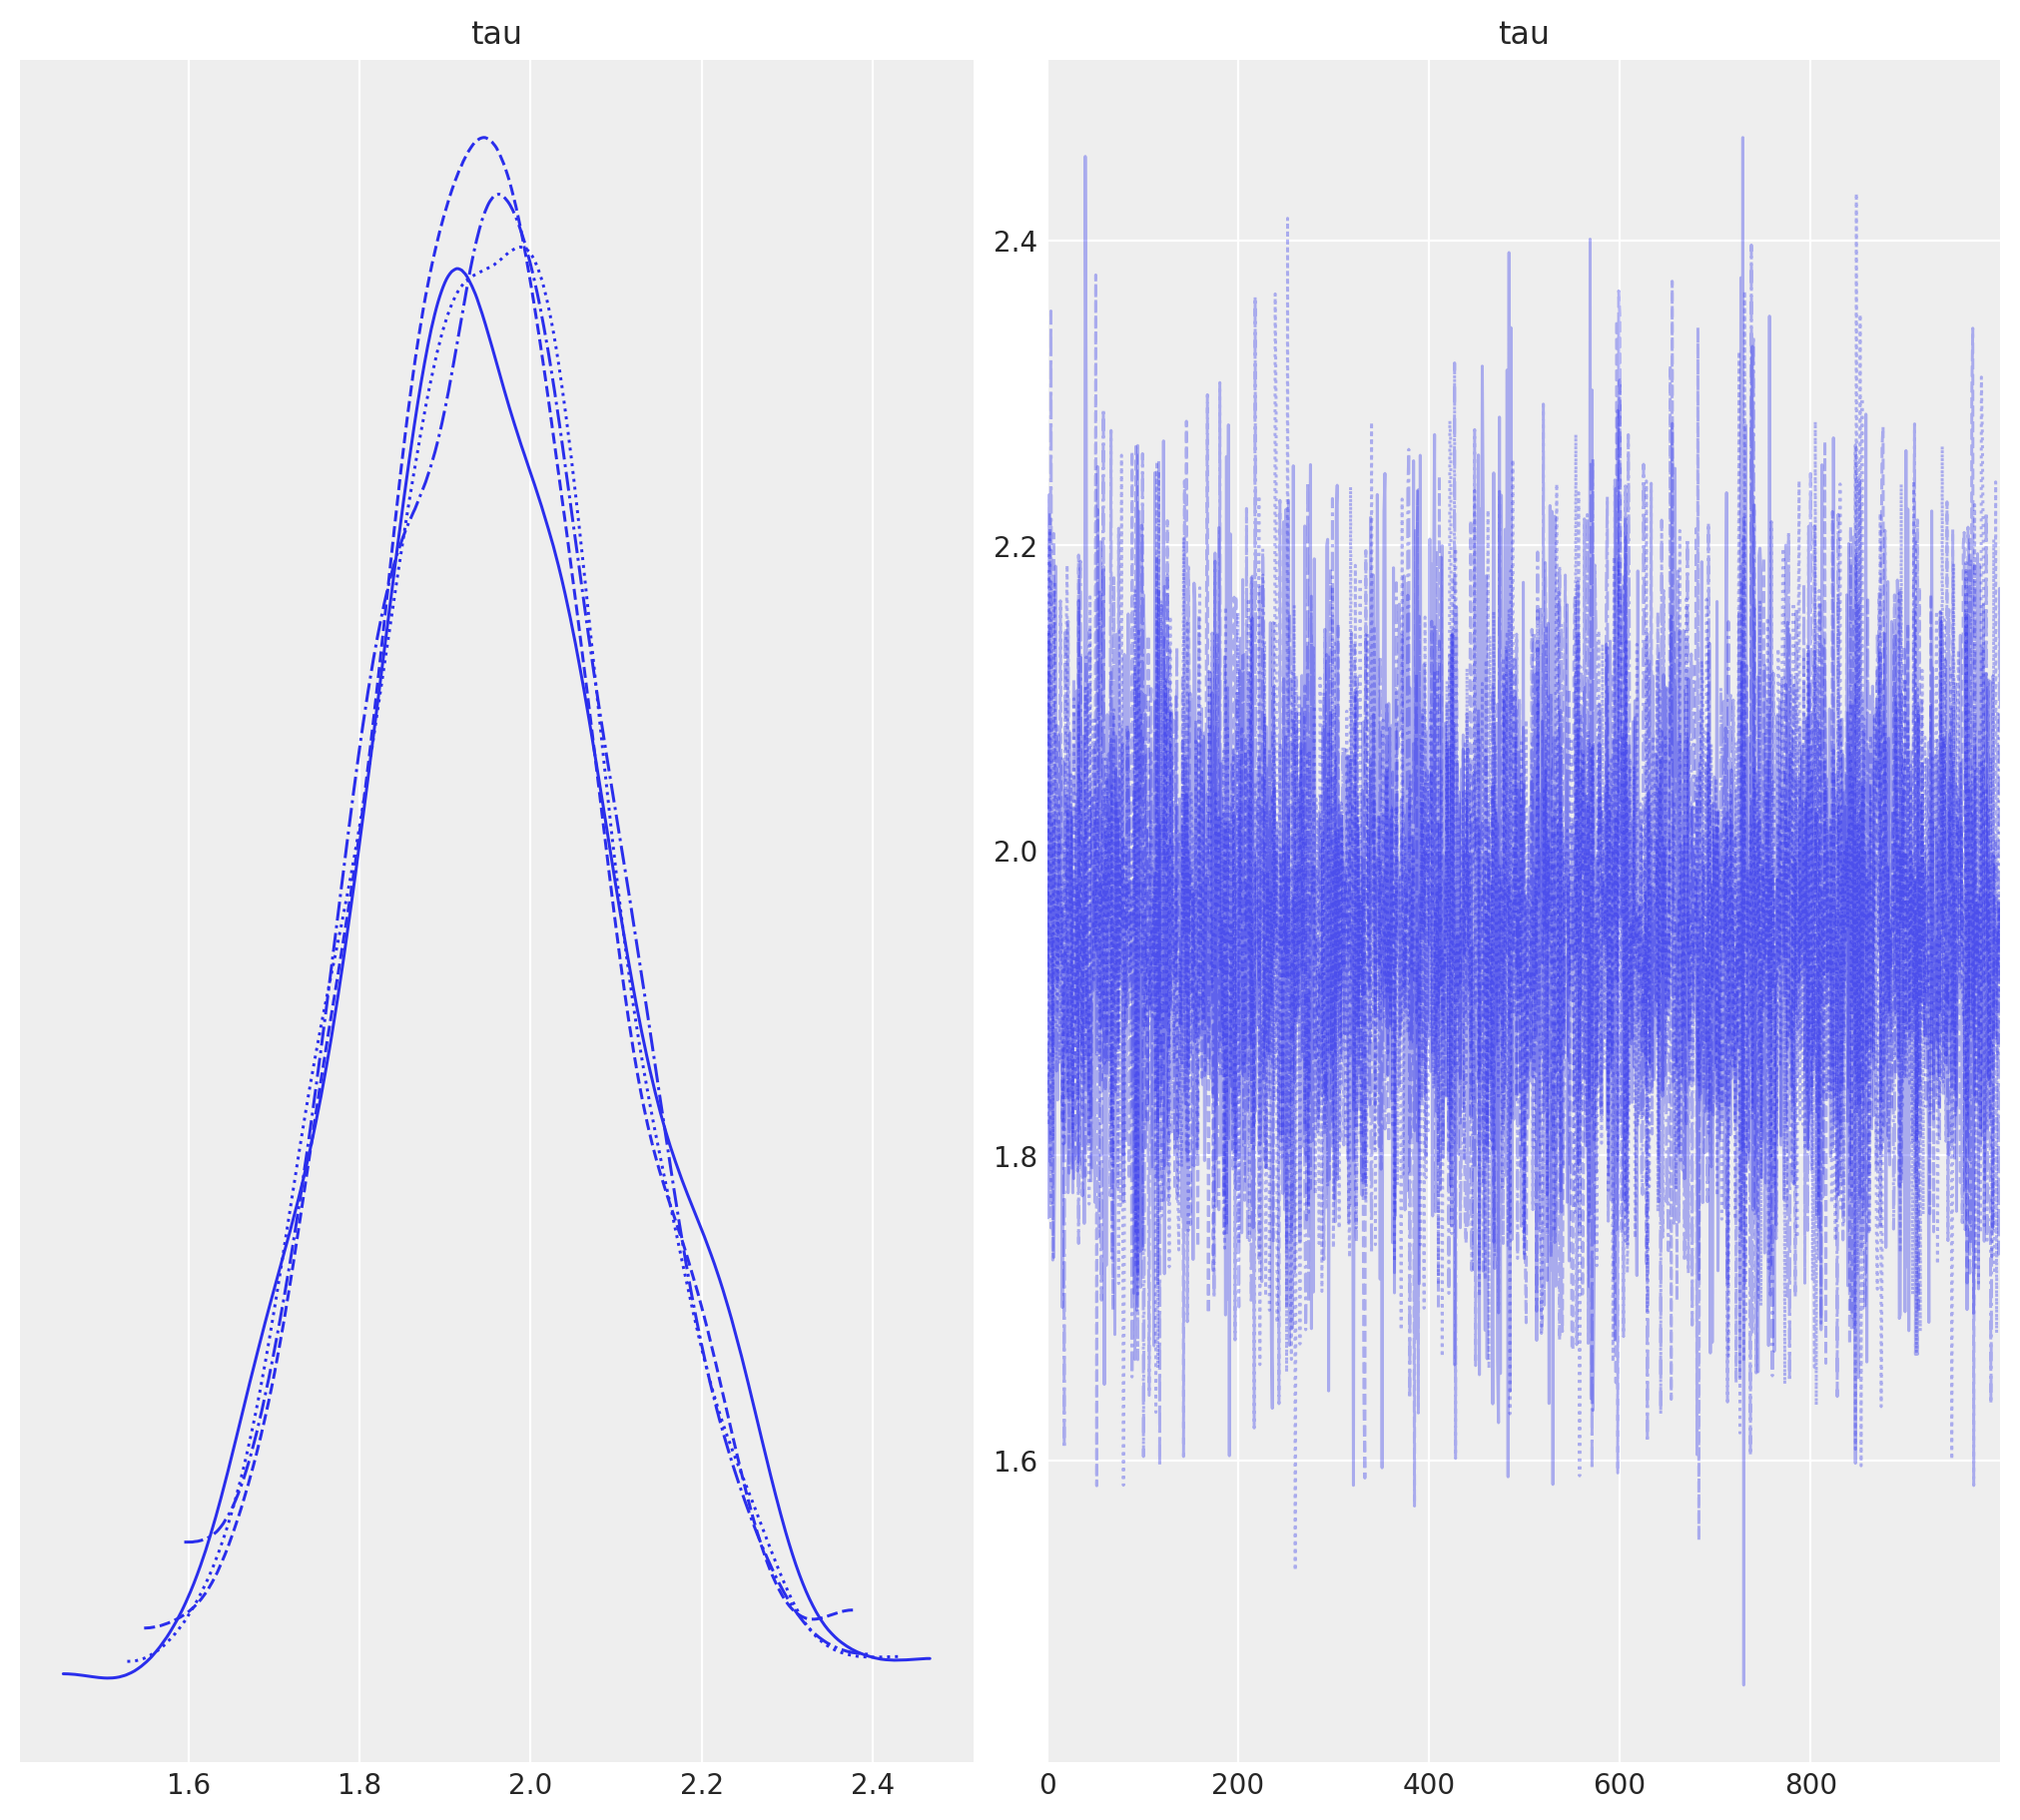

In [25]:
az.plot_trace(trace.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace.posterior["tau"],figsize=(10, 9))

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -2.039  0.158    -2.344     -1.726      0.002    0.002    5024.0   
beta[1] -1.922  0.186    -2.284     -1.570      0.003    0.002    5111.0   
tau      1.952  0.144     1.681      2.243      0.002    0.001    8768.0   

         ess_tail  r_hat  
beta[0]    2849.0    1.0  
beta[1]    2875.0    1.0  
tau        2631.0    1.0  


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

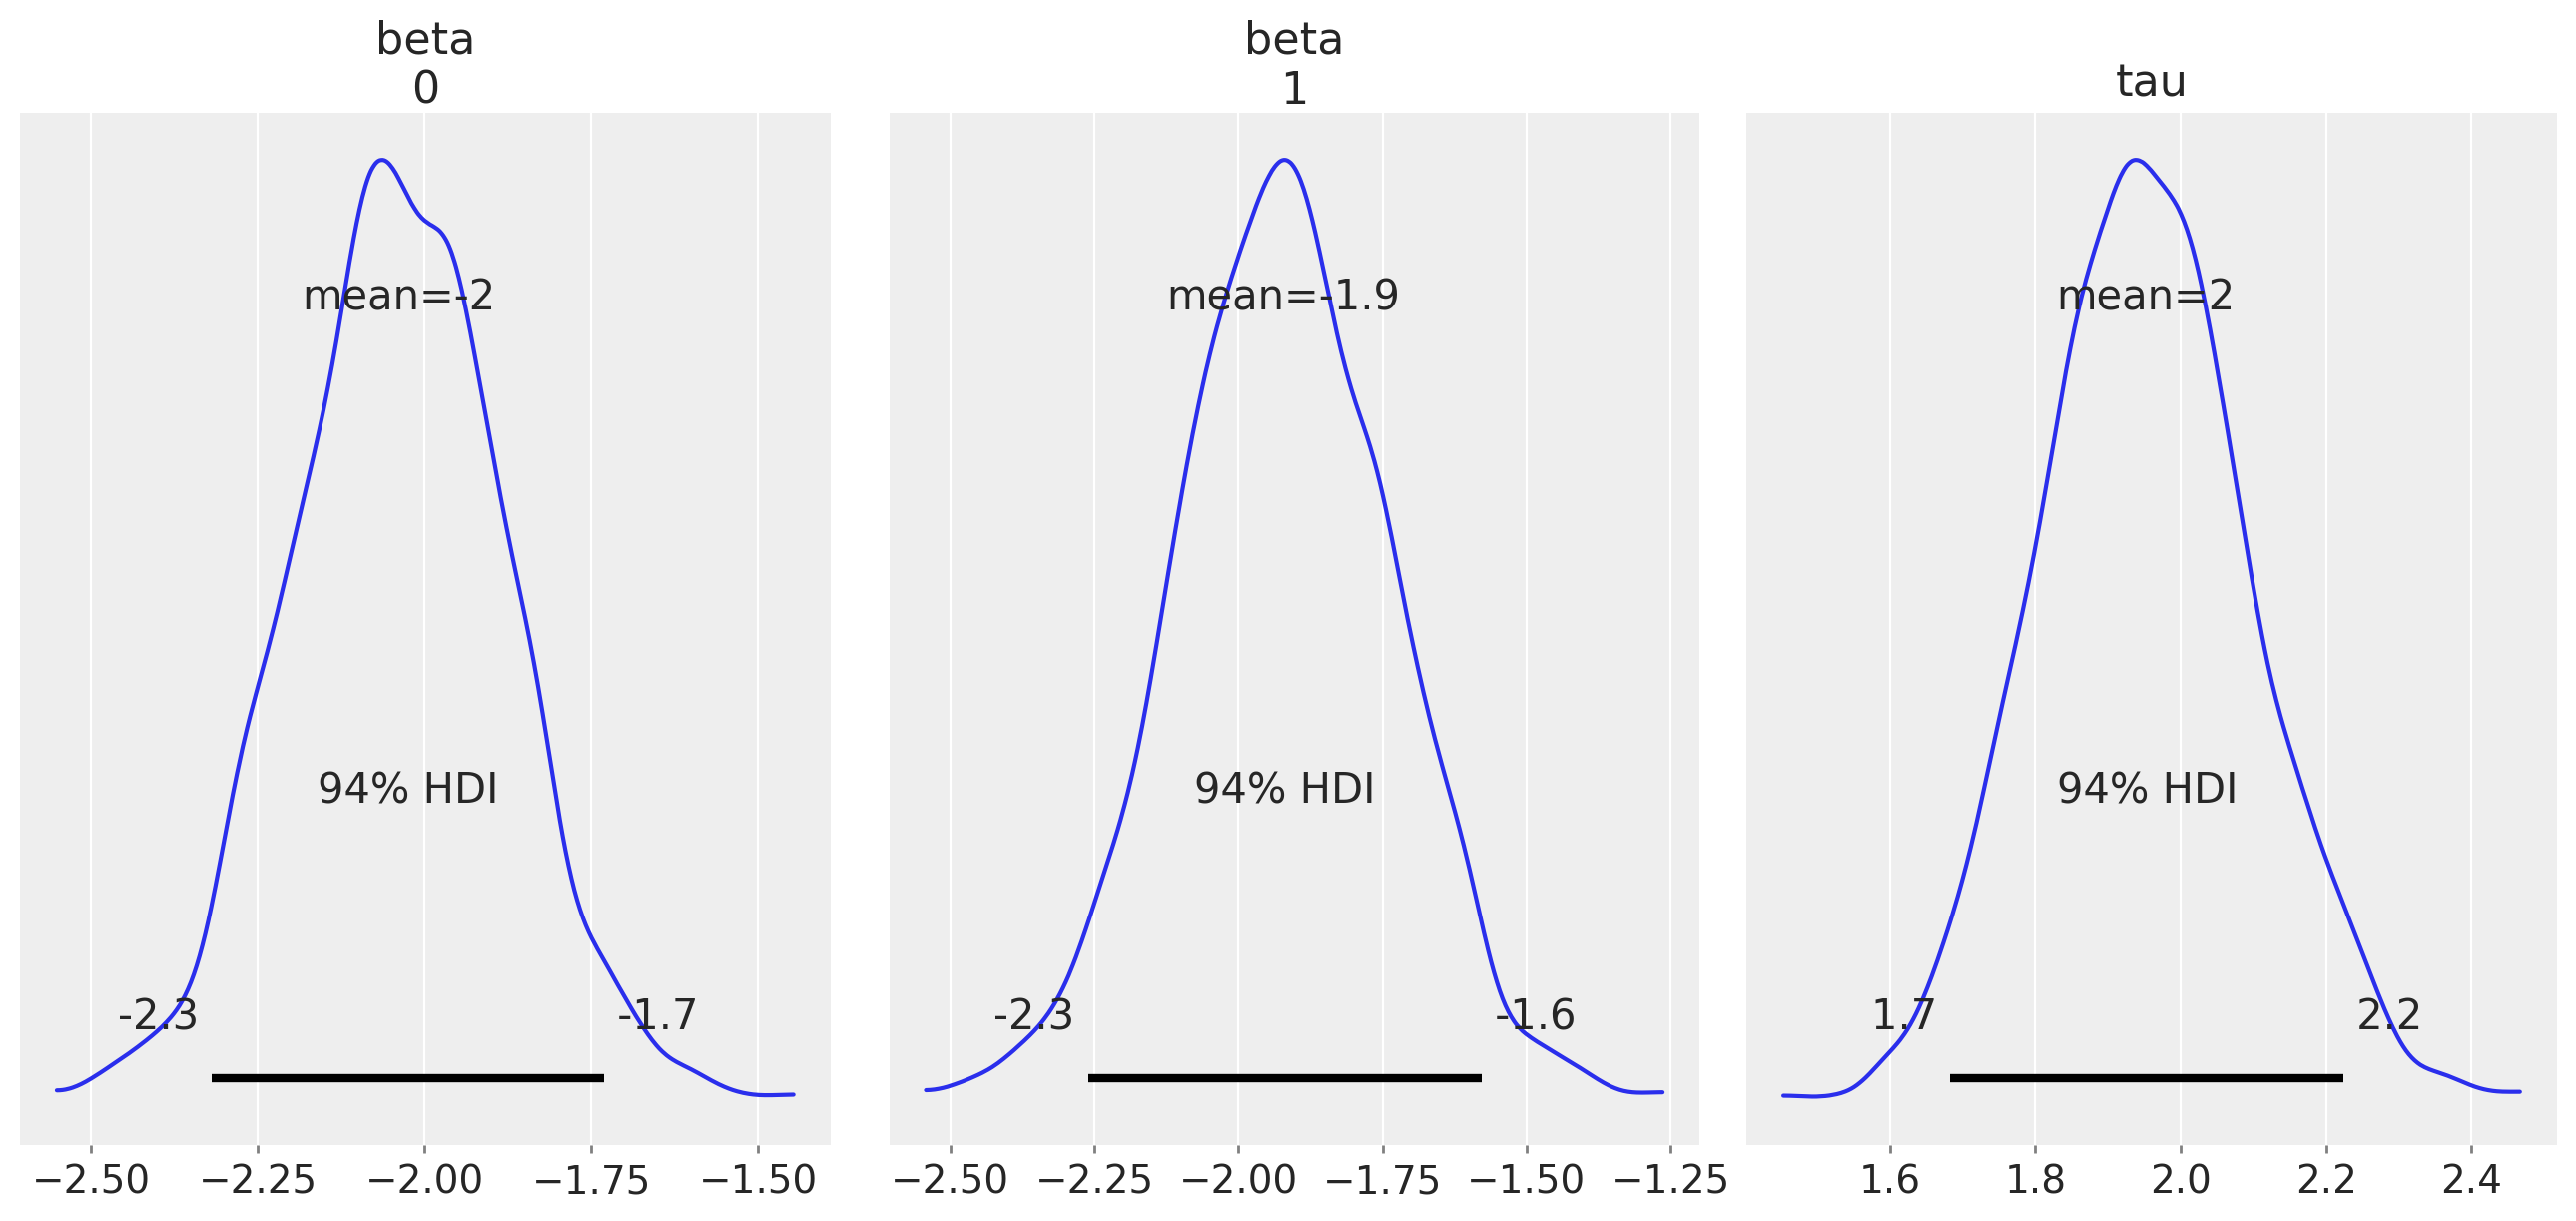

In [34]:
az.summary(trace.posterior[["beta","tau"]], hdi_prob=0.95)

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

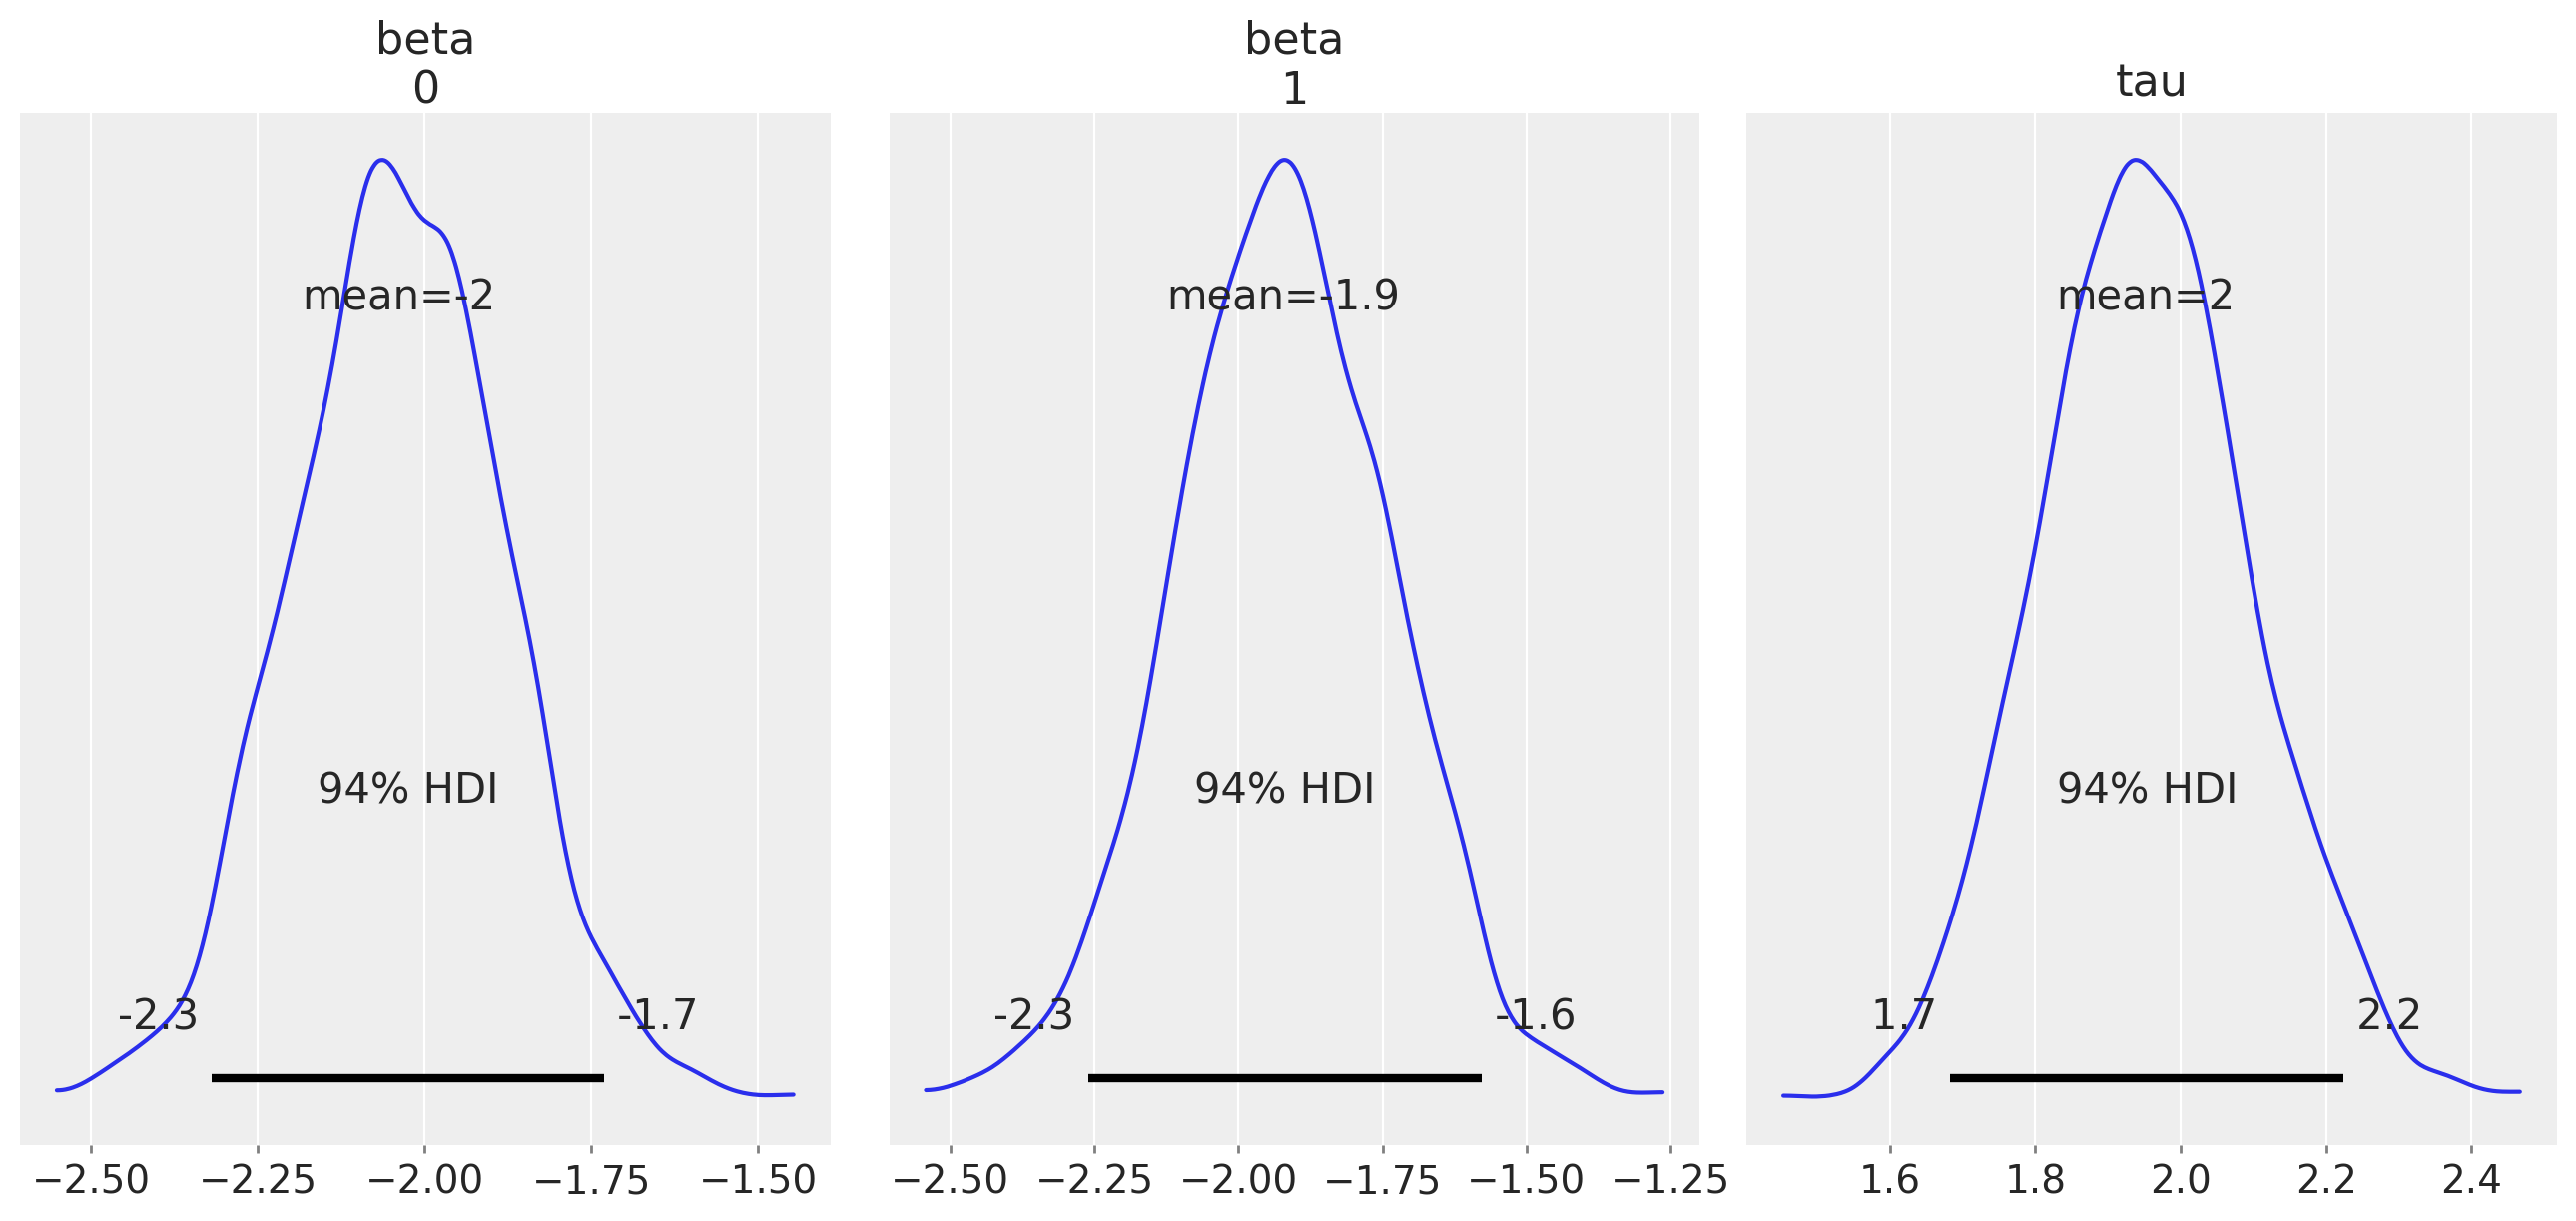

In [35]:
az.plot_posterior(trace.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

In [45]:
print(az.ess(trace,var_names=['beta']))

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 0 1
Data variables:
    beta        (beta_dim_0) float64 5.024e+03 5.111e+03


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

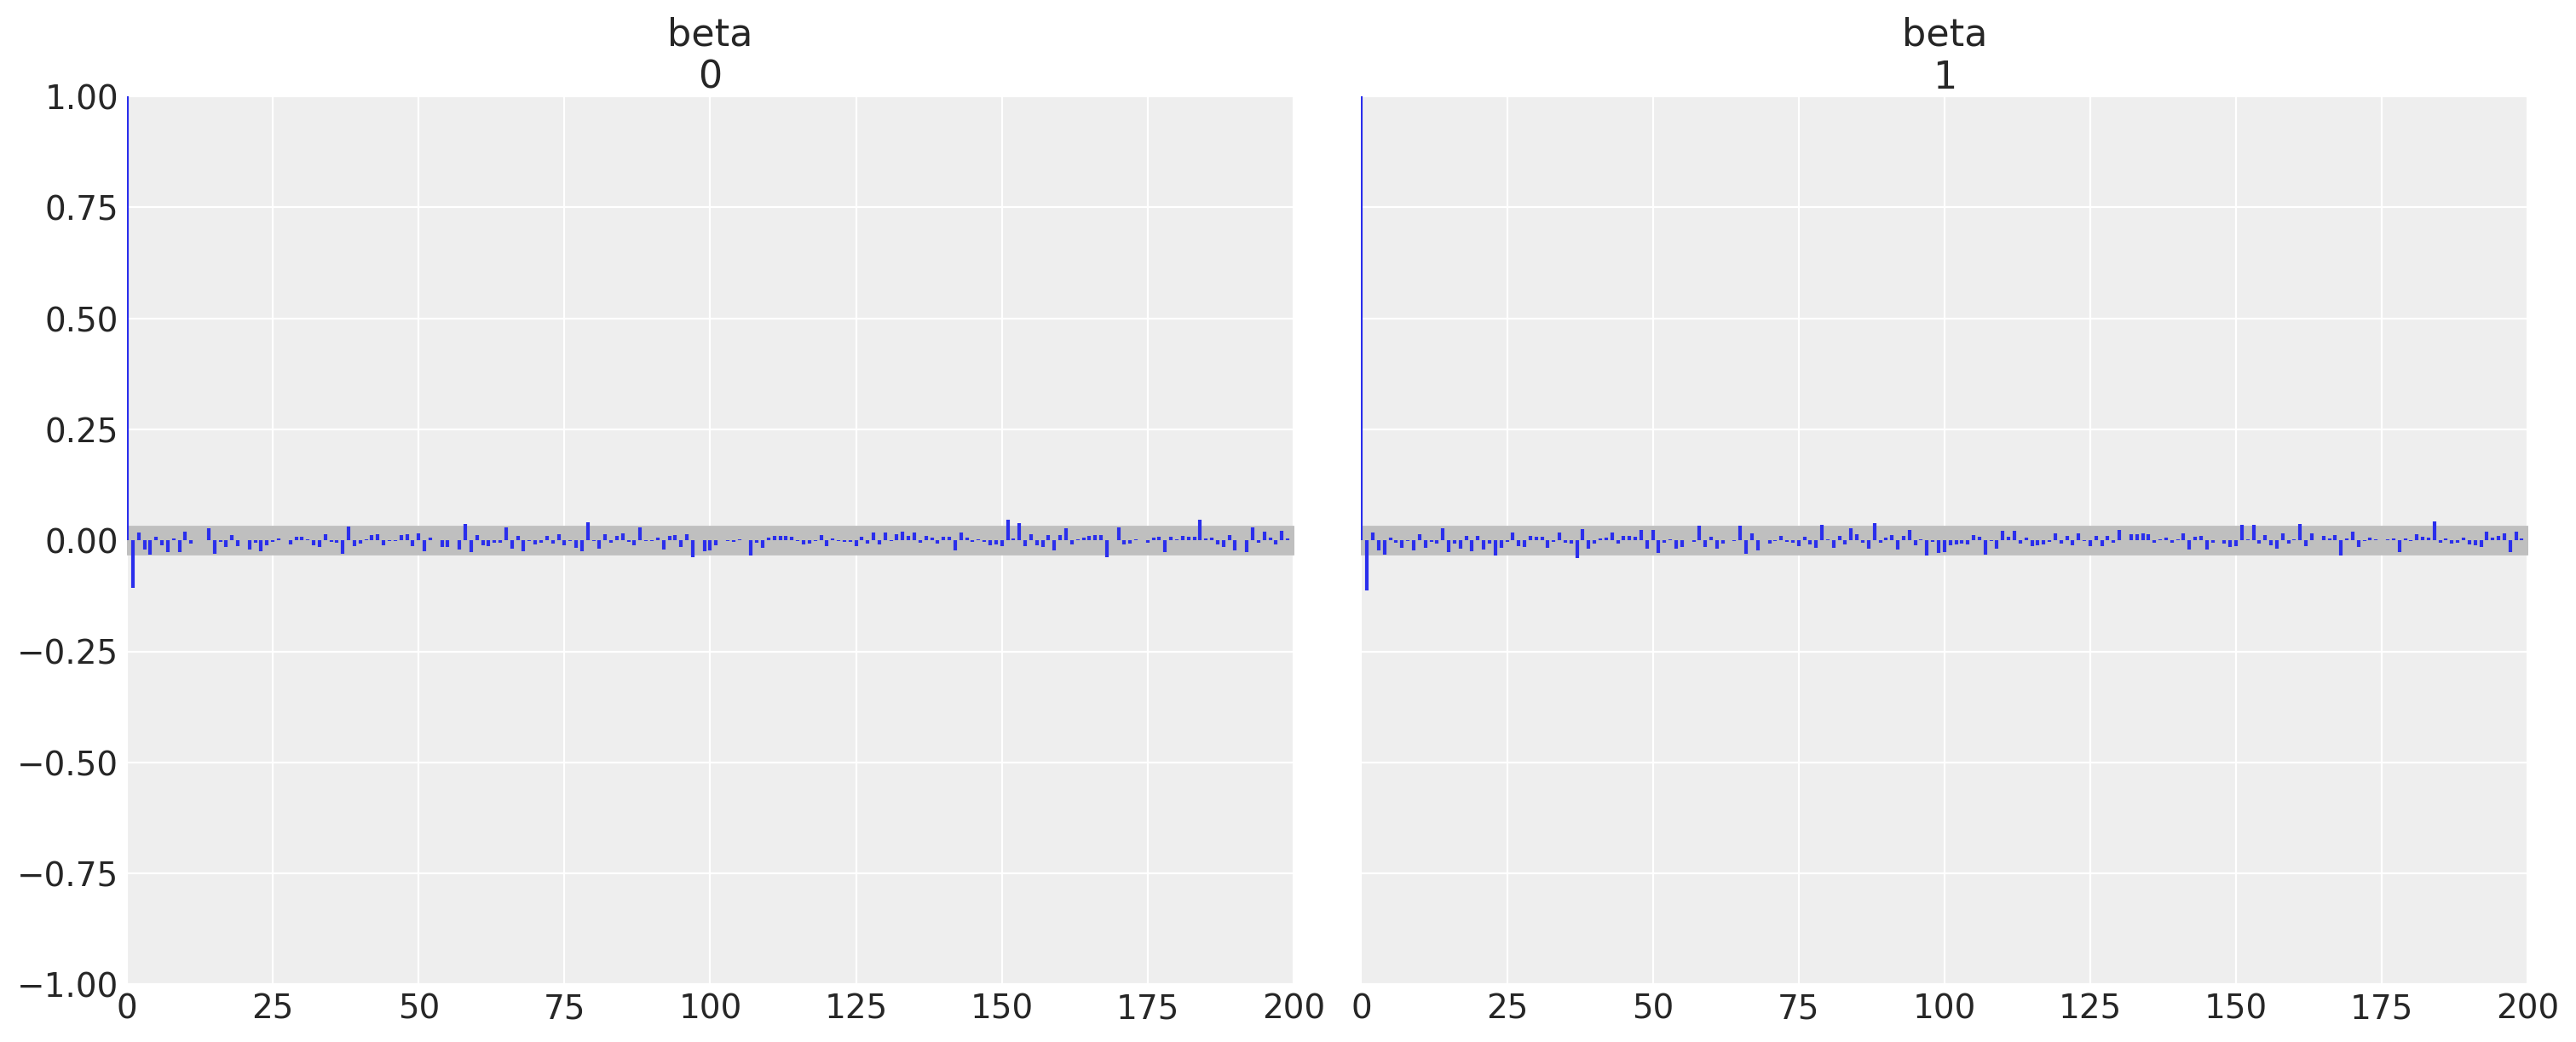

In [46]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))


In [48]:
# Posterior Predictive Sampling
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [X_star, Y_star]


<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, Y_star_dim_2: 203, X_star_dim_2: 203)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_star_dim_2  (Y_star_dim_2) int32 0 1 2 3 4 5 6 ... 197 198 199 200 201 202
  * X_star_dim_2  (X_star_dim_2) int32 0 1 2 3 4 5 6 ... 197 198 199 200 201 202
Data variables:
    Y_star        (chain, draw, Y_star_dim_2) float64 -3.222 -3.318 ... -4.781
    X_star        (chain, draw, X_star_dim_2) float64 0.6301 0.7887 ... 1.035
Attributes:
    created_at:                 2022-11-06T23:17:01.240629
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

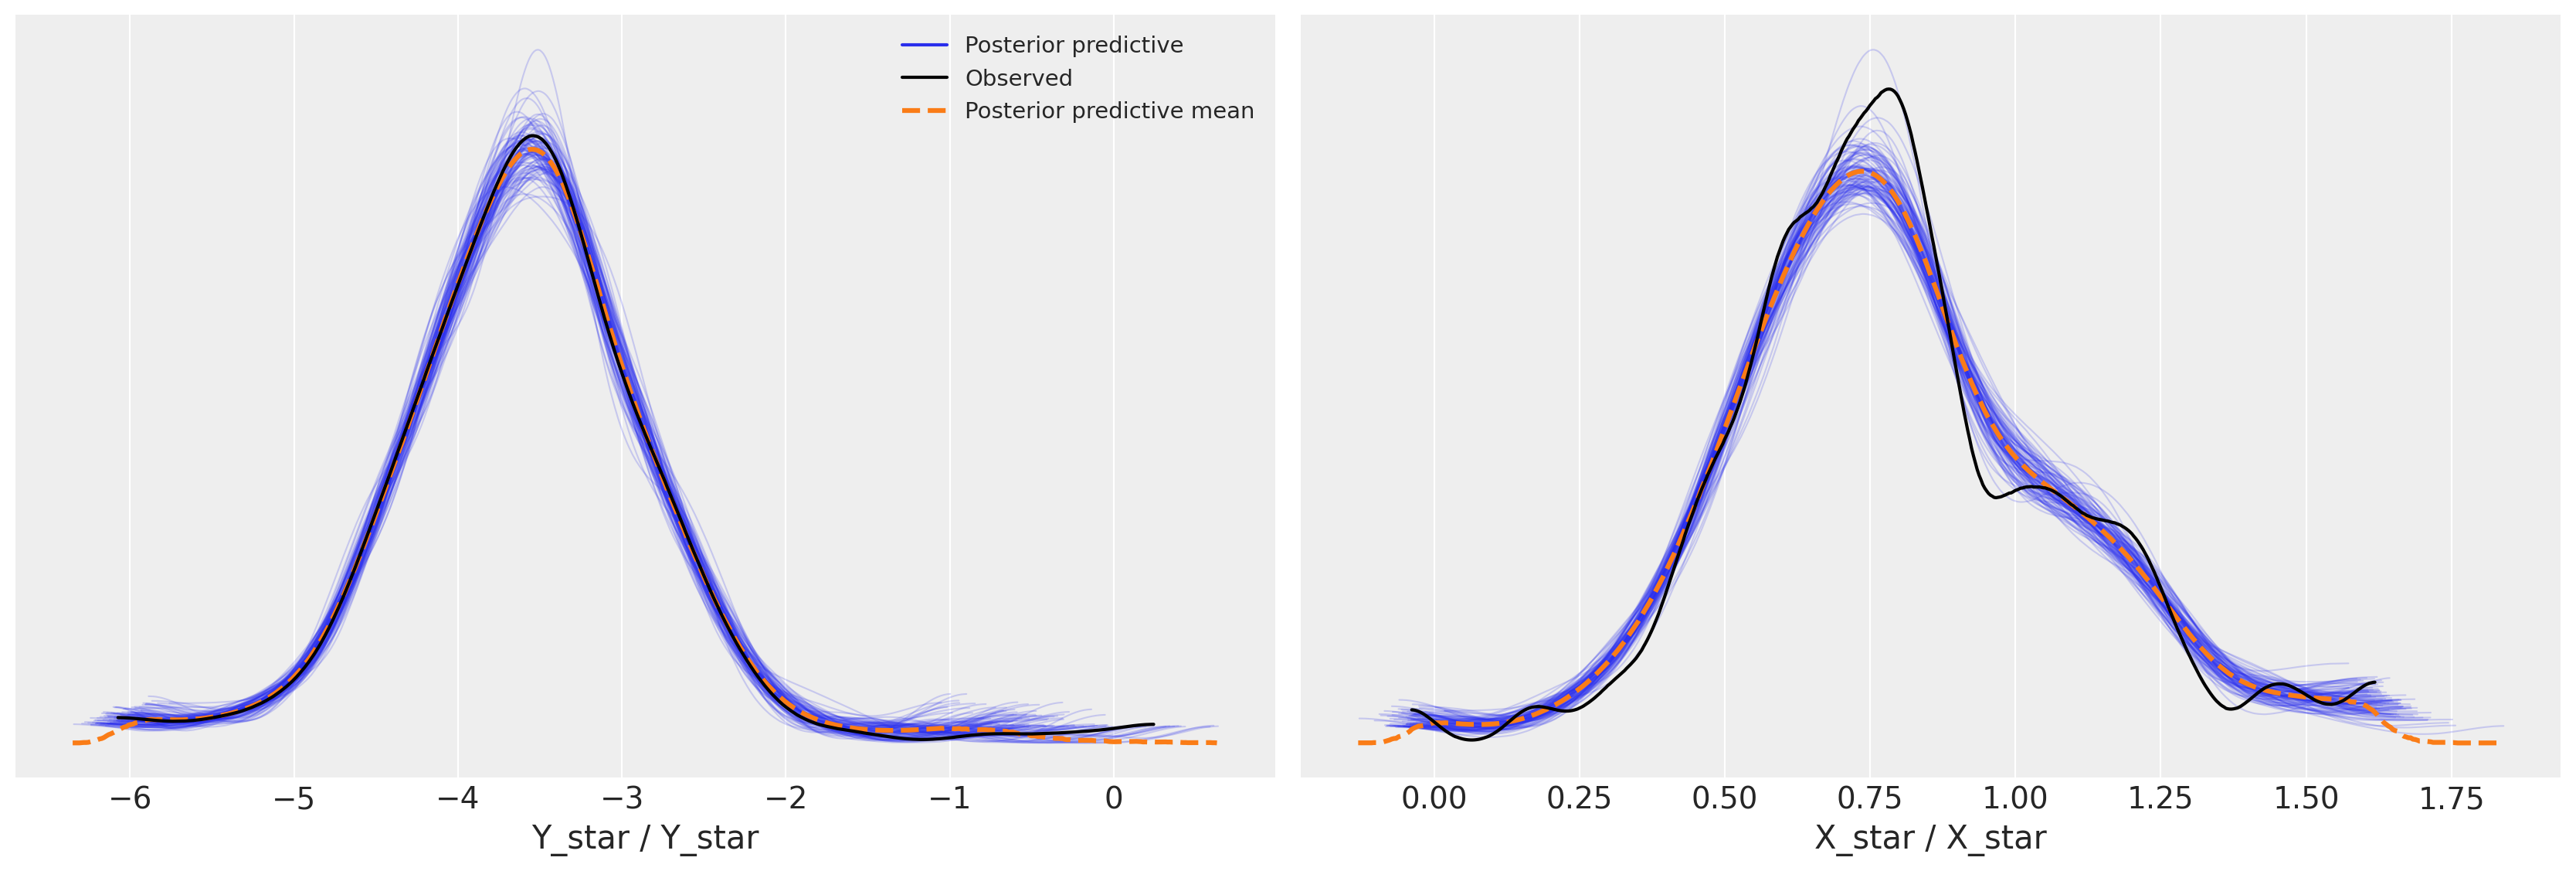

In [49]:
az.plot_ppc(trace, num_pp_samples=100);